In [ ]:
!unzip temp_dataset.zip

In [ ]:
import random
import os, cv2
import sys
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import numpy as np
import torch
import torchvision
from torch import nn
import albumentations as A
import torch.nn.functional as F
from torchvision.models import vgg16
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.metrics.cluster import homogeneity_score, completeness_score

**Dataset Downloader**

**Augmentation**

In [ ]:
alb_transforms = A.Compose(
    [
        # A.HorizontalFlip(),
        A.Rotate(limit=40, p=0.7)
    ]
)

**DatasetLoader**

In [ ]:
class DatasetLoader(Dataset):
    def __init__(self, dataset, split, train = True, alb_transforms=None):
      if train:
        data = dataset["data"][:split_length]
        labels = dataset["targets"][:split_length]
      else:
        data = dataset["data"][split_length:]
        labels = dataset["targets"][split_length:]
      
      self.label = []
      for label in labels:
        mask = cv2.imread(label, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (224,224), interpolation = cv2.INTER_CUBIC)
        mask = torch.from_numpy(mask)
        mask = mask.float()
        mean, std = torch.mean(mask), torch.std(mask)
        mask = (mask-mean)/std
        mask = mask.unsqueeze(2)
        mask = mask.movedim(2,0)
        self.label.append(mask)
      self.label = torch.stack(self.label)
      
      self.transform = False
      
      if alb_transforms is not None:
        self.transform = True
        data_alb = []
        data_image = []
        for image in tqdm(data):
          image = cv2.imread(image, cv2.IMREAD_COLOR)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = cv2.resize(image, (224,224), interpolation = cv2.INTER_CUBIC)
          image_np = image.copy()
          # normalizing image
          image = torch.from_numpy(image)
          image = image.float()
          mean, std = torch.mean(image), torch.std(image)
          image = (image-mean)/std
          # transforming and normalizing image
          image_alb = alb_transforms(image=image_np)["image"]
          image_alb = torch.from_numpy(image_alb)
          image_alb = image_alb.float()
          mean, std = torch.mean(image_alb), torch.std(image_alb)
          image_alb = (image_alb-mean)/std
          # image channel correction
          if len(image.shape) < 3:
            image = image.unsqueeze(0)
            image_alb = image_alb.unsqueeze(0)
          else:
            image = image.movedim(2,0)
            image_alb = image_alb.movedim(2,0)
          data_image.append(image)
          data_alb.append(image_alb)
          del image_np
        
        self.data_alb = torch.stack(data_alb)
        self.data = torch.stack(data_image)
      
      else:
        data_image = []
        for image in tqdm(data):
          image = cv2.imread(image, cv2.IMREAD_COLOR)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = cv2.resize(image, (224,224), interpolation = cv2.INTER_CUBIC)
          image = torch.from_numpy(image)
          # normalizing image
          image = image.float()
          mean, std = torch.mean(image), torch.std(image)
          image = (image-mean)/std
          # image channel correction
          if len(image.shape) < 3:
            image = image.unsqueeze(0)
          else:
            image = image.movedim(2,0)
          data_image.append(image)
        self.data = torch.stack(data_image)


    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.label[idx]

        if self.transform:
          image_alb = self.data_alb[idx]
          return (image, image_alb, label)
        else:
          return (image, label)

In [ ]:
# dataset creation
img_list = os.listdir("/content/temp_dataset/image/")
img_list = ["/content/temp_dataset/image/" + x for x in img_list]
mask_list = os.listdir("/content/temp_dataset/mask/")
mask_list = ["/content/temp_dataset/mask/" + x for x in mask_list]
print(len(img_list))
print(len(mask_list))
dataset = {
    "data": img_list,
    "targets": mask_list
}

100
100


In [ ]:
split_length = int(0.95*len(dataset["data"]))
print("Train dataset: ", split_length)
print("Test dataset: ", len(dataset["data"])-split_length)
# training data
print("Training Dataset --->")
trainDatasetLoader = DatasetLoader(dataset, split_length, train = True,
                                   alb_transforms=alb_transforms)
dataloader_train = DataLoader(trainDatasetLoader, batch_size=2, shuffle=True, num_workers=0)
# # validation data
print("Validation Dataset --->")
valDatasetLoader = DatasetLoader(dataset, split_length, train = False,
                                   alb_transforms=alb_transforms)
dataloader_val = DataLoader(valDatasetLoader, batch_size=1, shuffle=True, num_workers=0)

Train dataset:  95
Test dataset:  5
Training Dataset --->


  0%|          | 0/95 [00:00<?, ?it/s]

Validation Dataset --->


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
val = next(iter(dataloader_train))
print(val[0].shape)
print(val[1].shape)
print(val[2].shape)
del val

torch.Size([2, 3, 224, 224])
torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 224, 224])


**Model**

In [ ]:
class IICSegmentationModel(nn.Module):
    def __init__(self, n_classes, n_clusters, vgg_pretrained=True):
        super(IICSegmentationModel, self).__init__()
        
        # Load pre-trained VGG16
        self.trunk = vgg16(pretrained=vgg_pretrained)
    
        # Freeze trunk parameters
        for param in self.trunk.parameters():
            param.requires_grad = False
        
        # Modify classifier for feature extraction
        self.trunk.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512)
        )
        
        # Define clustering heads
        self.heads = nn.ModuleList([nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, n_clusters)
        ) for _ in range(2)])
        
        # Define segmentation head
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, n_classes, kernel_size=1, stride=1, padding=0)
        )
        
    def forward(self, x):
        features = self.trunk.features(x)
        output = self.trunk(x)
        assignments = [head(output) for head in self.heads]
        
        # Compute segmentation mask
        mask = self.segmentation_head(features)
        mask = F.interpolate(mask, size=x.shape[2:], mode='bilinear', align_corners=True)
        
        return mask, assignments

In [ ]:
# weight initializer
def weight_init(model):
    if isinstance(model, nn.Conv2d):
        nn.init.xavier_normal_(model.weight, gain=nn.init.calculate_gain("relu"))
        if model.bias is not None:
            nn.init.zeros_(model.bias)

    elif isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight)
        if model.bias is not None:
            nn.init.zeros_(model.bias)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)
model = IICSegmentationModel(5,5)
model.to(device)
print("The model is transfered to", device)
model.apply(weight_init)
print("The weights are Initialised.")

Using cuda


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 240MB/s]


The model is transfered to cuda
The weights are Initialised.


In [ ]:
val = next(iter(dataloader_train))
input_batch = val[0]
input_batch = input_batch.to(device)
mask, assignments = model(input_batch)
print("Mask:", mask.shape)
print("Clustering Head output:", assignments)

Mask: torch.Size([2, 5, 224, 224])
Clustering Head output: [tensor([[-0.7839, -0.2270, -0.2405,  0.4883,  0.6877],
        [-0.7398, -0.1643, -0.3582,  0.5683,  0.0232]], device='cuda:0',
       grad_fn=<AddmmBackward0>), tensor([[ 0.0897,  0.0551,  0.3892, -0.2015,  0.2914],
        [ 0.1340,  0.4177,  0.3434, -0.1430, -0.5110]], device='cuda:0',
       grad_fn=<AddmmBackward0>)]


**Loss**

In [ ]:
def IID_loss(x_out, x_tf_out, lamb=1.0, EPS=sys.float_info.epsilon):
    # shape: [2,10] * [10,2] => [2,2]
    p_i_j = torch.matmul(x_out, x_tf_out.T)
    p_i_j = (p_i_j + p_i_j.t()) / 2.0
    p_i_j = p_i_j / p_i_j.sum() # Normalization
    
    # shape: [2,2] -> [2,2]
    p_i = p_i_j.sum(dim=1)
    p_j = p_i_j.sum(dim=0)
    # avoid NaN losses
    p_i_j[(p_i_j < EPS).data] = EPS
    p_j[(p_j < EPS).data] = EPS
    p_i[(p_i < EPS).data] = EPS

    loss = -p_i_j * (torch.log(p_i_j) - lamb * torch.log(p_j) - lamb * torch.log(p_i))
    return loss.sum()

In [ ]:
loss = IID_loss(torch.cat(assignments, dim=1), torch.cat(assignments, dim=1))
print(loss)

tensor(-0.0267, device='cuda:0', grad_fn=<SumBackward0>)


In [ ]:
def segmentation_loss(outputs, outputs_tf, num_clusters, lambda_value=1.0):
    # Compute the softmax of the outputs
    # p = F.softmax(outputs, dim=1)
    # print(p.shape)

    # Compute the cross-entropy loss
    ce_loss = F.cross_entropy(outputs, outputs_tf, reduction='mean')
    # print(ce_loss)

    # # Compute the L2 distance between the centroid and the outputs
    # centroids = torch.zeros(num_clusters, outputs.size(1), device=outputs.device)
    # print(centroids.shape)
    # for k in range(num_clusters):
    #     centroids[k] = p[outputs_tf == k].mean(dim=0)
    #     print(p[outputs_tf == k].mean(dim=0))
    # print(p.unsqueeze(2).shape)
    # print(centroids.unsqueeze(0).unsqueeze(0))
    # l2_loss = ((p - centroids.unsqueeze(0).unsqueeze(0)) ** 2).sum(dim=1).mean()

    # # Compute the segmentation loss
    # loss = ce_loss + lambda_value * l2_loss

    return ce_loss


In [ ]:
# loss testing
input_batch = val[0]
input_batch = input_batch.to(device)
aug_image_batch = val[1]
aug_image_batch = aug_image_batch.to(device)

lamb = 1.0
outputs = model(input_batch)
outputs_tf = model(aug_image_batch)

In [ ]:
loss = IID_loss(torch.cat(outputs[1], dim=1), torch.cat(outputs_tf[1], dim=1))
print(loss)

tensor(-21.1604, device='cuda:0', grad_fn=<SumBackward0>)


In [ ]:
segmentation_loss(outputs[0], outputs_tf[0], 5)

tensor(-7.8923, device='cuda:0', grad_fn=<DivBackward1>)

In [ ]:
del val

**Evaluation Function**

**Auxilary Function**

In [ ]:
def print_while_trainig(epoch, loss_history):
    plt.figure(figsize=(8, 6), dpi=80)
    epochs_list = list(range(epoch+1))
    plt.plot(epochs_list, loss_history, label="train_loss")
    plt.legend()
    plt.grid()
    plt.show()

**Training Code**

In [ ]:
def train(modeldataset, dataloader, dataloader_val, optimizer, epochs=100,
    device=torch.device("cpu"), eval_every=5, lamb=1.0,
    overcluster_period=20, overcluster_ratio=0.5):
    
    loss_history = []
    best_cluster_loss = 0
    best_overcluster_loss = 0
    
    for epoch in range(epochs):
        print("Epoch {}/{}:".format(epoch+1, epochs))
        model.train()
        temp_loss= []
        for batch in tqdm(dataloader):
            optimizer.zero_grad()
            inputs = batch[0]
            inputs_tf = batch[1]
            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)
            outputs = model(inputs)
            outputs_tf = model(inputs_tf)
            loss = IID_loss(torch.cat(outputs[1], dim=1), torch.cat(outputs_tf[1], dim=1))
            loss += segmentation_loss(outputs[0], outputs_tf[0], 5)
            temp_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        
        losses = sum(temp_loss)/len(temp_loss)
        loss_history.append(losses)
        if losses < best_cluster_loss:
            best_cluster_loss = losses
            torch.save(model.state_dict(), "/content/best_seg_loss_model.pth")
        print_while_trainig(epoch, loss_history)
    print("Best Clustering Loss Value:", best_cluster_loss)

Epoch 1/20:


  0%|          | 0/48 [00:00<?, ?it/s]

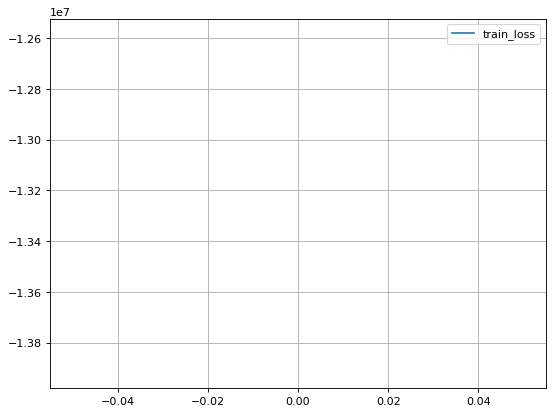

Epoch 2/20:


  0%|          | 0/48 [00:00<?, ?it/s]

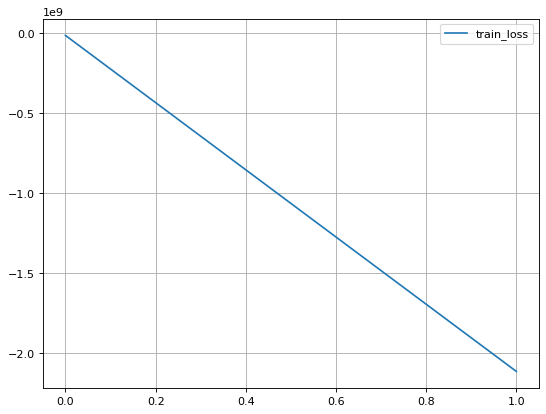

Epoch 3/20:


  0%|          | 0/48 [00:00<?, ?it/s]

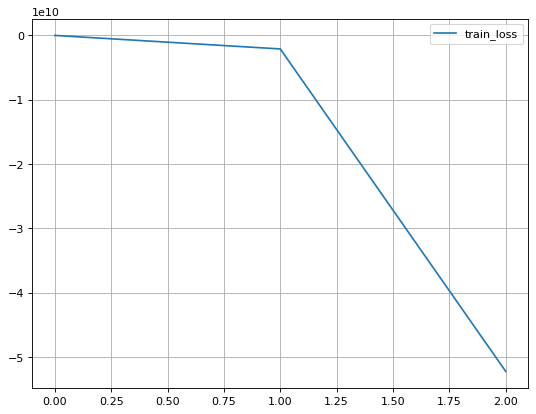

Epoch 4/20:


  0%|          | 0/48 [00:00<?, ?it/s]

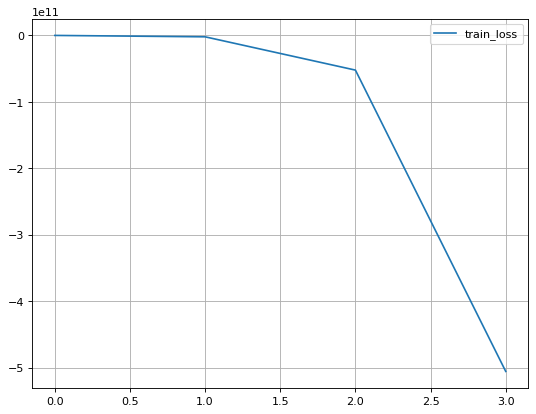

Epoch 5/20:


  0%|          | 0/48 [00:00<?, ?it/s]

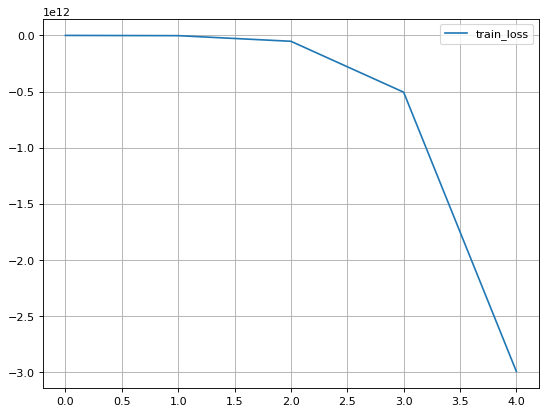

Epoch 6/20:


  0%|          | 0/48 [00:00<?, ?it/s]

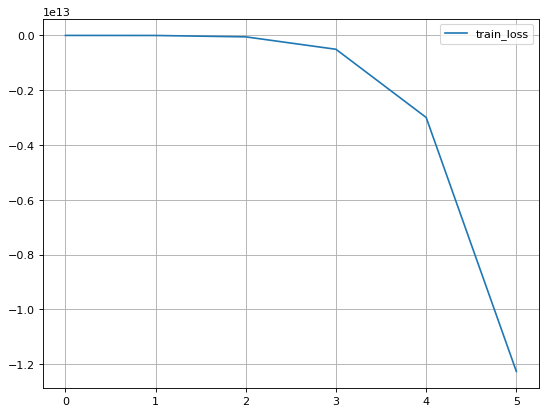

Epoch 7/20:


  0%|          | 0/48 [00:00<?, ?it/s]

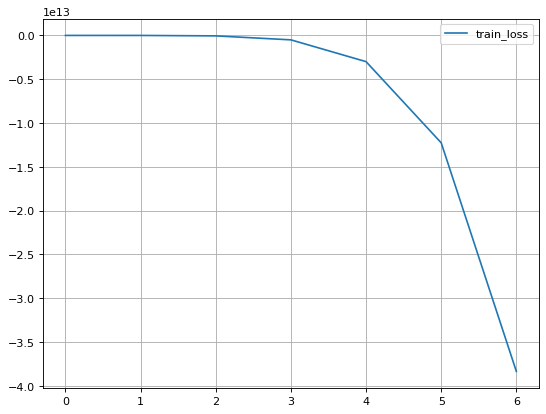

Epoch 8/20:


  0%|          | 0/48 [00:00<?, ?it/s]

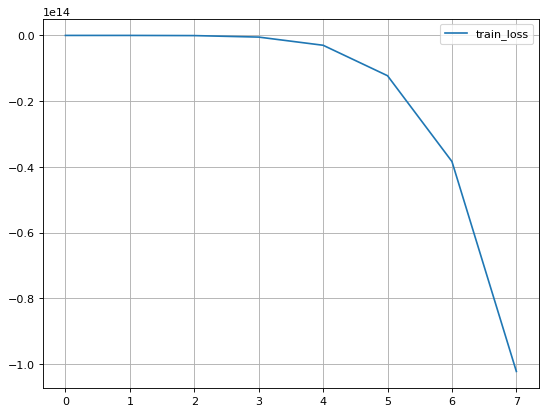

Epoch 9/20:


  0%|          | 0/48 [00:00<?, ?it/s]

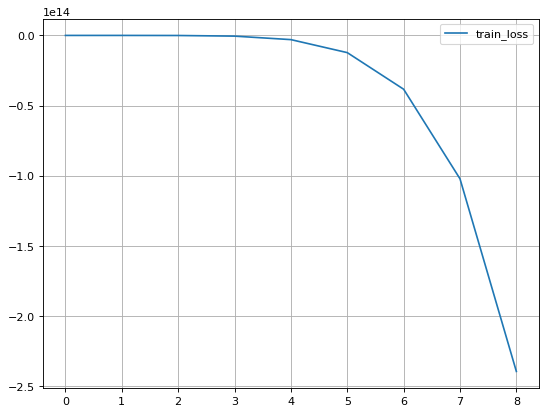

Epoch 10/20:


  0%|          | 0/48 [00:00<?, ?it/s]

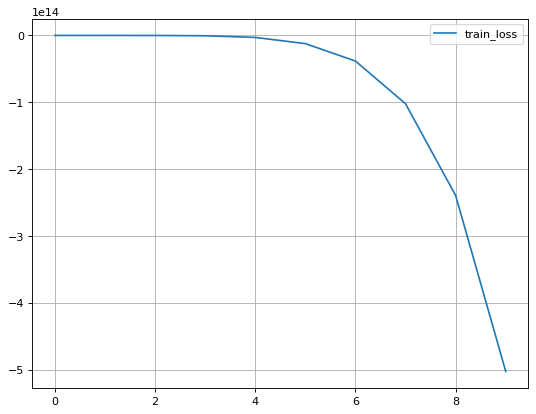

Epoch 11/20:


  0%|          | 0/48 [00:00<?, ?it/s]

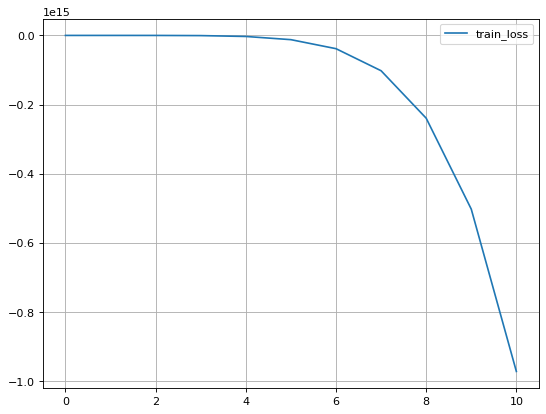

Epoch 12/20:


  0%|          | 0/48 [00:00<?, ?it/s]

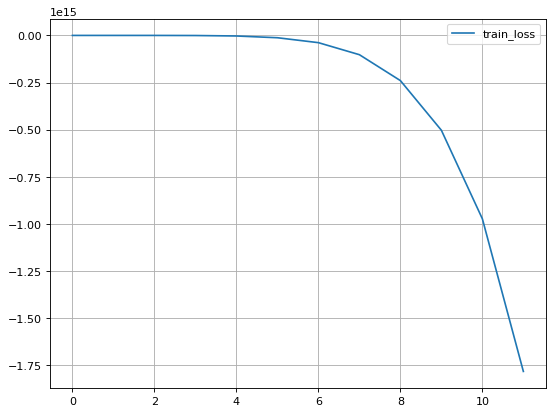

Epoch 13/20:


  0%|          | 0/48 [00:00<?, ?it/s]

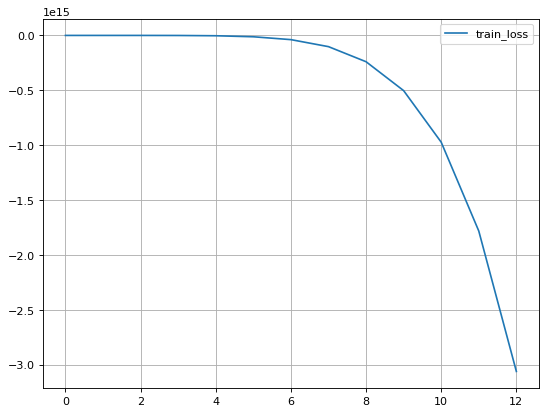

Epoch 14/20:


  0%|          | 0/48 [00:00<?, ?it/s]

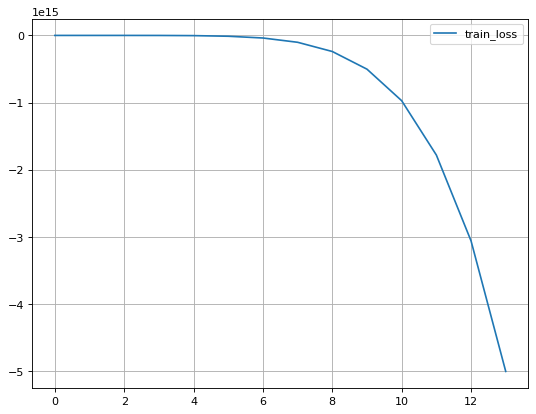

Epoch 15/20:


  0%|          | 0/48 [00:00<?, ?it/s]

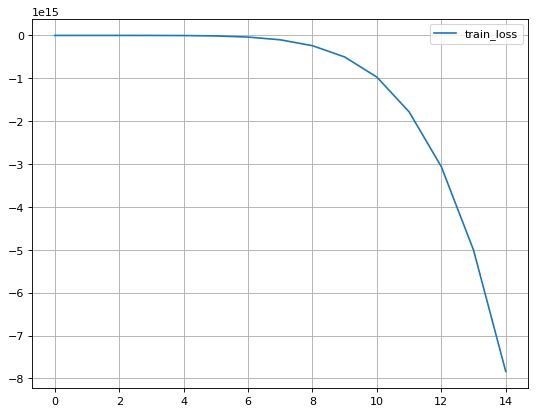

Epoch 16/20:


  0%|          | 0/48 [00:00<?, ?it/s]

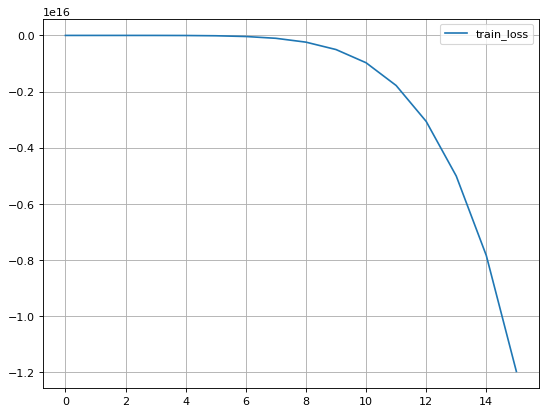

Epoch 17/20:


  0%|          | 0/48 [00:00<?, ?it/s]

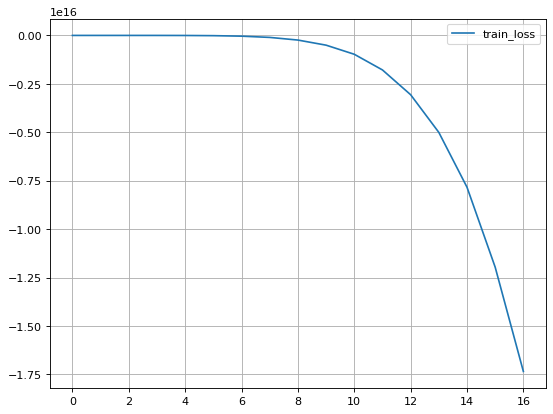

Epoch 18/20:


  0%|          | 0/48 [00:00<?, ?it/s]

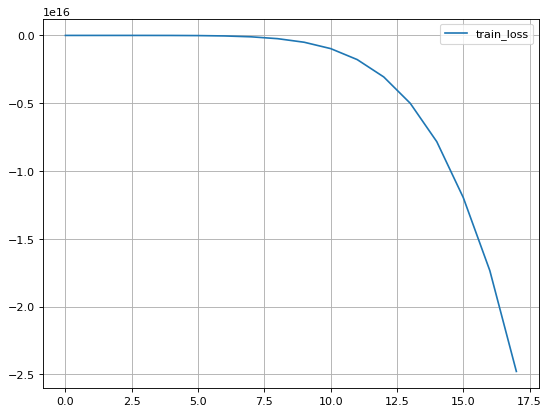

Epoch 19/20:


  0%|          | 0/48 [00:00<?, ?it/s]

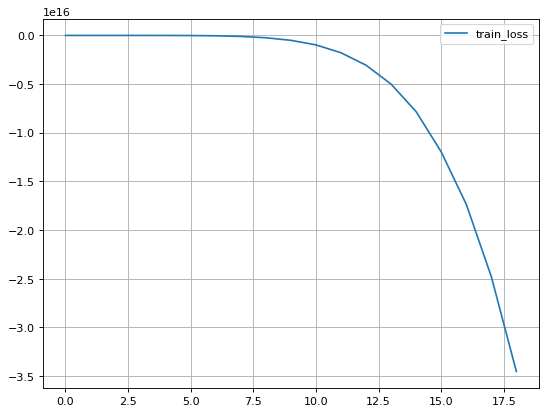

Epoch 20/20:


  0%|          | 0/48 [00:00<?, ?it/s]

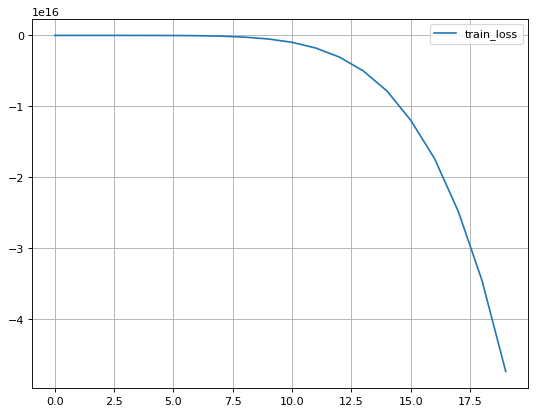

Best Clustering Loss Value: -4.732402740249668e+16


In [ ]:
# training
optimizer = torch.optim.Adam(
    model.parameters(), lr=4e-4, betas=(0.9, 0.999), eps=1e-08,
    weight_decay=0, amsgrad=False)

train( model, dataloader_train, dataloader_val,
    optimizer, device=device, epochs=20, lamb=1.2,
    overcluster_period=20, overcluster_ratio=0.5)

**Loading best model**

In [ ]:
test_model = IICSegmentationModel(5,5)
test_model.load_state_dict(torch.load("/content/best_seg_loss_model.pth"))
test_model.to(device)

IICSegmentationModel(
  (trunk): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

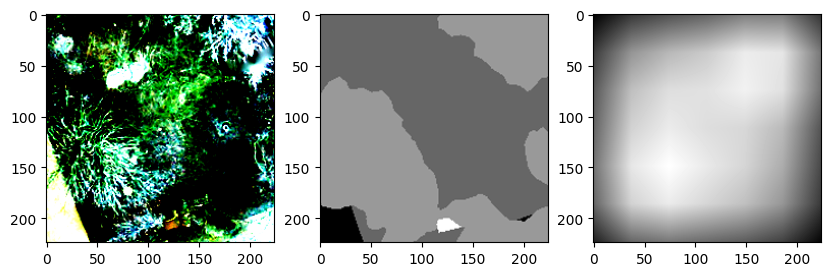

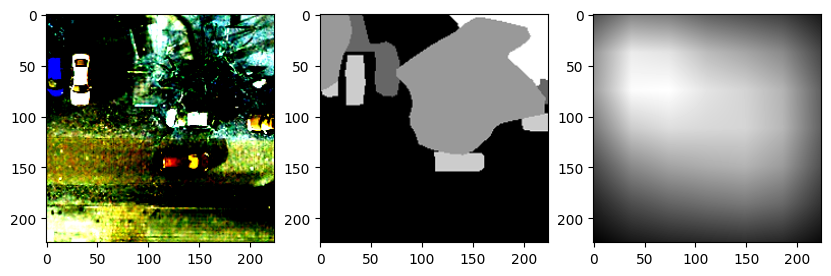

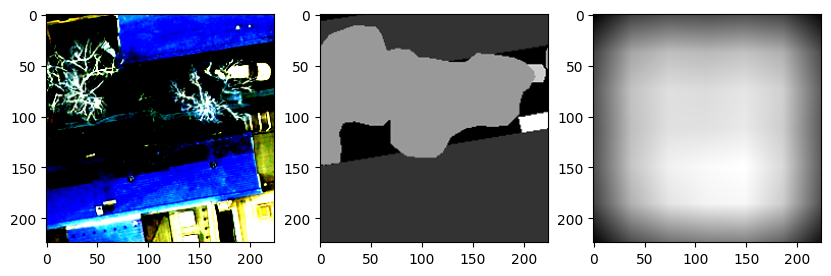

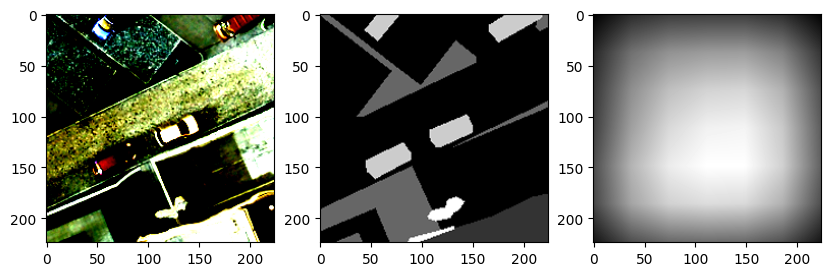

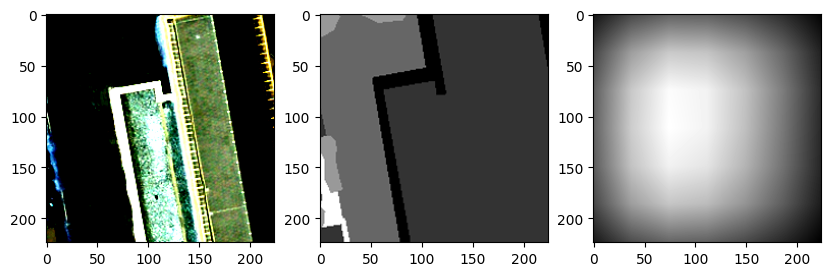

In [ ]:
def model_test(model, dataloader, device=torch.device("cpu"), output_count=5):
    model.eval()
    counter = 1
    for batch in dataloader:
        if counter > output_count:
          break
        image = batch[0].to(device)
        label = batch[2].to(device)
        outputs = model(image)
        cluster_labels = torch.max(outputs[0], dim=1)[0]

        # plots
        plt.figure(figsize=(10,10))

        image = torch.movedim(image, 1, 3)
        image = torch.squeeze(image).cpu().numpy()
        plt.subplot(1,3,1)
        plt.imshow(image)
        
        label = torch.movedim(label, 1, 3)
        label = torch.squeeze(label,0).cpu().numpy()
        plt.subplot(1,3,2)
        plt.imshow(label, cmap="gray")
        
        cluster_labels = torch.movedim(cluster_labels, 0, 2)
        cluster_labels = cluster_labels.cpu().detach().numpy()
        plt.subplot(1,3,3)
        plt.imshow(cluster_labels, cmap="gray")
        plt.plot()

model_test(test_model, dataloader_val, device=device, output_count=5)

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
 
%matplotlib inline
 
# Read in the image
original_image = cv2.imread('/content/drive/MyDrive/DLA Lab (my)/1_ZWHQ35Y1C0DuGEB2cXoOWQ.png')
 

In [ ]:
img=cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)

In [ ]:
vectorized = img.reshape((-1,3))

In [ ]:
vectorized = np.float32(vectorized)

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [ ]:
K = 3
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

In [ ]:
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))

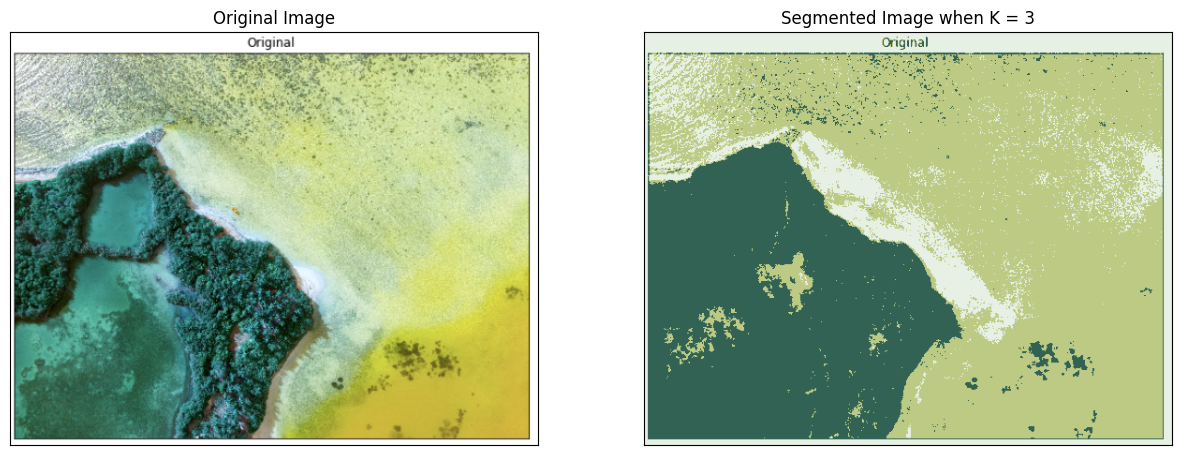

In [ ]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
gausBlur = cv2.GaussianBlur(original_image, (11,11),0)

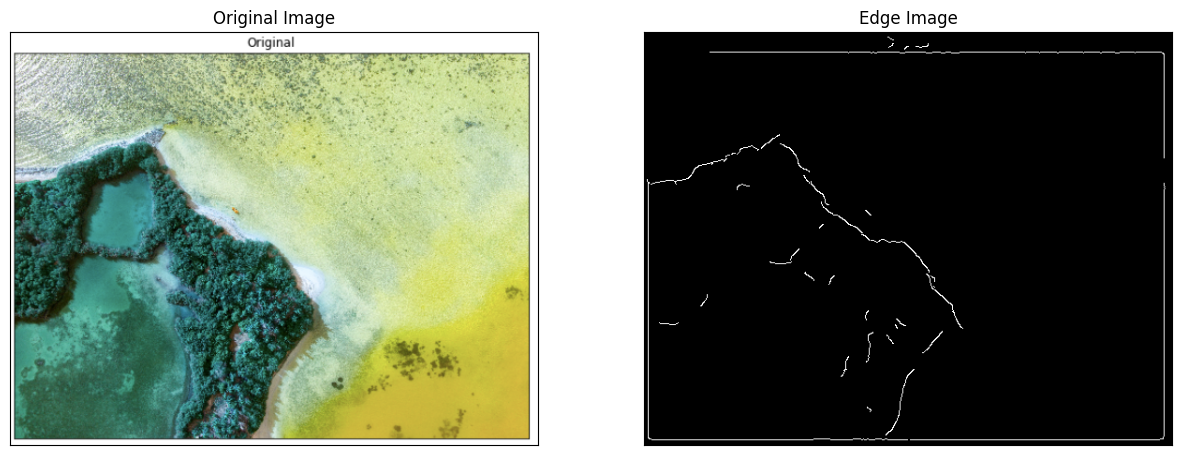

In [ ]:
edges = cv2.Canny(gausBlur,150,200)
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
import numpy as np
import cv2
from sklearn.cluster import SpectralClustering
from sklearn.manifold import spectral_embedding
from sklearn.metrics.pairwise import rbf_kernel
from scipy.sparse import csgraph

# Load the image
img = cv2.imread('/content/drive/MyDrive/DLA Lab (my)/1_ZWHQ35Y1C0DuGEB2cXoOWQ.png', 0)

# Define the parameters for the subtractive clustering algorithm
sigma = 1
threshold = 0.3

# Create the affinity matrix for the image
affinity_matrix = rbf_kernel(img, gamma=1.0/sigma)

# Compute the Laplacian matrix for the affinity matrix
laplacian = csgraph.laplacian(affinity_matrix, normed=True)

# Compute the spectral clustering using the subtractive algorithm
clustering = SpectralClustering(n_clusters=2, eigen_solver='arpack',
                                affinity='precomputed', n_init=10,
                                gamma=1.0/sigma, n_neighbors=10,
                                eigen_tol="auto", assign_labels='discretize')
laplacian = np.nan_to_num(laplacian, nan=1e-4, posinf=1e-2, neginf=-1e-2)
clustering.fit(laplacian)

# Reshape the labels to the original image dimensions
segmented_image = clustering.labels_.reshape(img.shape)

# Display the segmented image
cv2.imshow('Segmented Image', segmented_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/sparse/csgraph/_laplacian.py:546: RuntimeWarning: invalid value encountered in sqrt
  w = np.where(isolated_node_mask, 1, np.sqrt(w))


ValueError: ignored

In [ ]:
img.shape()

AttributeError: ignored

In [ ]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
import tensorflow as tf

# Load the image
img = cv2.imread('/content/drive/MyDrive/DLA Lab (my)/1_ZWHQ35Y1C0DuGEB2cXoOWQ.png')

# Resize the image to a fixed size
img = cv2.resize(img, (256, 256))

# Preprocess the image for the CNN
img = img.astype(np.float32) / 255.0
img = tf.expand_dims(img, axis=0)

# Load the pre-trained CNN model
model = tf.keras.models.load_model('/path/to/model.h5')

# Use the model to predict the segmentation mask
mask = model.predict(img)[0]

# Reshape the mask to the original image dimensions
mask = np.argmax(mask, axis=-1)
mask = cv2.resize(mask.astype(np.uint8), (img.shape[2], img.shape[1]))

# Apply K-means clustering to the masked image
kmeans = KMeans(n_clusters=2)
masked_image = cv2.cvtColor(img[0].numpy(), cv2.COLOR_RGB2GRAY)
masked_image = cv2.threshold(masked_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
masked_image = cv2.bitwise_and(masked_image, masked_image, mask=mask)
masked_image = masked_image.reshape((-1, 1))
labels = kmeans.fit_predict(masked_image)

# Reshape the labels to the original image dimensions
labels = labels.reshape((img.shape[1], img.shape[2]))

# Display the segmented image
cv2.imshow('Segmented Image', labels.astype(np.uint8))
cv2.waitKey(0)
cv2.destroyAllWindows()


OSError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
